In [6]:
import tensorflow as tf
import make_layers as hpred
import importlib
importlib.reload(hpred)
import matplotlib.pyplot as plt
import numpy as np
import os

os.environ["CUDA_VISIBLE_DEVICES"]="1"

tot = 200000
p = .01
tlen = 100

#var = dec^2 var + b

s1 = .5
s2 = 1.
dec1 = .9
dec2 = .5
b1 = np.sqrt((1. - dec1**2)*s1*s1)
b2 = np.sqrt((1. - dec2**2)*s2*s2)
V = [b1,b2]


(1, 180000, 1)
(1, 20002, 1)


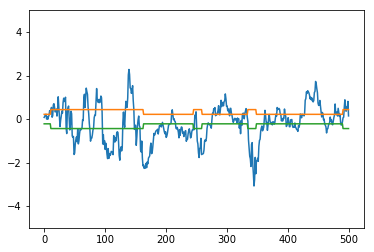

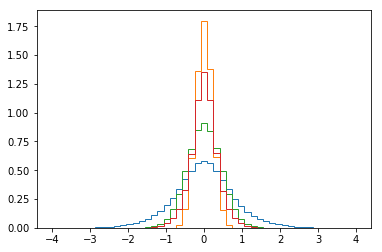

In [7]:
trans = np.random.uniform(0,1,[tot])

state = [np.random.randint(2)]

for k in trans:
    if k < p:
        state.append(1 - state[-1])
    else:
        state.append(state[-1])
state = np.array(state)
data = [np.random.normal(0,V[state[0]]**2)]

rand = np.random.randn(tot+1)

for k in range(len(state)):
    data.append(dec[state[k]] * data[-1] + V[state[k]]*rand[k])

data = np.expand_dims(np.expand_dims(np.array(data),0),-1)

data += np.random.standard_normal(data.shape)*.01

test_frac = int(.9*tot)
dat = data[:,:test_frac]
var = data[:,test_frac:]

print(dat.shape)
print(var.shape)
plen = 500
plt.plot(data[0,:plen,0])
plt.plot(V[1]*state[:plen] + V[0]*(1-state[:plen])) 
plt.plot(-V[1]*state[:plen] - V[0]*(1-state[:plen]))
plt.ylim([-5,5])
plt.show()

t1 = V[0]*np.random.randn(int(tot/2))
t2 = V[1]*np.random.randn(int(tot/2))

plt.hist(data[0,:,0],np.linspace(-4,4,50),histtype = "step",normed = True)
plt.hist(t1,np.linspace(-4,4,50),histtype = "step",normed = True)
plt.hist(t2,np.linspace(-4,4,50),histtype = "step",normed = True)
plt.hist(np.concatenate([t1,t2]),np.linspace(-4,4,50),histtype = "step",normed = True)
plt.show()

In [10]:

def get_hres_results(hres,data,session):
    pred = []
    final_act = [np.zeros([int(x) for x in k.shape],dtype = np.float32) for k in hres.init_activity]
    
    for k in range(len(data)):
        repl_dict = {}
        for j in range(len(hres.layers)):
            repl_dict[hres.init_activity[j]] = final_act[j]

        repl_dict[hres.data] = data[k]

        P,final_act = sess.run([hres.get_attribute("prediction"),hres.final_activation],repl_dict)
        pred.append(P)
    
    return pred

def trainable(scope = "",match = True):
    a = tf.trainable_variables()
    if match:
        return [x for x in a if x.name[:len(scope)] == scope]
    else:
        return [x for x in a if x.name[:len(scope)] != scope]
    
def make_training_funciton(hres):
    loss,loss_list = hres.prediction_loss()

    adam = tf.train.AdamOptimizer(learning_rate = .001)

    weights = trainable()

    wl = .0001*tf.reduce_sum([tf.reduce_sum(tf.abs(w)) for w in weights])

    train = adam.minimize(loss + wl)
    
    return train,loss,loss_list

tf.reset_default_graph()

isize = [1,tlen,1]

hp1 = hpred.hpred(isize,[10])#,stop_fwd_grad = False,stop_bwd_grad = True)
hp2 = hpred.hpred(isize,[10,10])#,stop_fwd_grad = False,stop_bwd_grad = True)
hp3 = hpred.hpred(isize,[10,10,10])#,stop_fwd_grad = False,stop_bwd_grad = True)

hp = [hp1,hp2,hp3]

tvals = [make_training_funciton(h) for h in hp]
train = [t[0] for t in tvals]
loss_list = [t[2] for t in tvals]

final_activation = [A.final_activation for A in hp]

init = tf.global_variables_initializer()

(100, 10)
(100, 10)
(100, 10)


In [14]:
sess = tf.Session()
sess.run(init)

loss_list = [t[2] for t in tvals]

final_act = [[np.zeros([int(x) for x in k.shape],dtype = np.float32) for k in a.init_activity] for a in hp]
losses = [[] for a in final_act]

for k in range(0,int(test_frac/tlen) - 1):
    for h in range(len(hp)):
        repl_dict = {}
        for j in range(len(hp[h].layers)):
            repl_dict[hp[h].init_activity[j]] = final_act[h][j]


        repl_dict[hp[h].data] = dat[:,tlen*k : tlen * (k+1)]
        LOSS = sess.run(loss_list[h],repl_dict)
        losses[h].append(LOSS)
        _,final_act_temp = sess.run([train[h],hp[h].final_activation],repl_dict)
        
        final_act[h] = final_act_temp
        
    print("{}\t{}\t{}\t{}".format(round(float(k*tlen)/test_frac,2),losses[0][-1],losses[1][-1],losses[2][-1]))


0.0	[50.910984]	[50.910984, 22.203556]	[50.910984, 73.128036, 45.189857]
0.0	[155.80627]	[155.71809, 94.007935]	[155.63609, 129.94925, 54.562664]
0.0	[51.837311]	[51.875935, 29.801292]	[51.821842, 41.944454, 17.024252]
0.0	[77.793213]	[77.855804, 47.13089]	[77.764511, 48.707214, 14.245515]
0.0	[39.109554]	[39.086952, 7.2845325]	[39.138996, 64.894829, 41.196541]
0.0	[31.954403]	[31.953985, 6.8539925]	[31.918669, 48.757992, 30.194298]
0.0	[112.75748]	[112.67171, 59.699276]	[112.83025, 65.767548, 17.112545]
0.0	[133.46161]	[133.50214, 16.63192]	[133.15359, 214.50401, 133.27159]
0.0	[31.881758]	[31.884159, 8.0815802]	[31.846287, 37.912365, 21.535927]
0.01	[30.006615]	[30.007759, 11.841611]	[30.009329, 22.035242, 9.0944901]
0.01	[31.352165]	[31.348795, 4.8842077]	[31.355282, 42.017349, 24.386515]
0.01	[17.609573]	[17.614708, 7.2672362]	[17.605974, 10.208148, 3.0554404]
0.01	[38.173016]	[38.18277, 13.958993]	[38.171749, 24.867237, 9.0296946]
0.01	[80.411606]	[80.40596, 13.149352]	[80.430382,

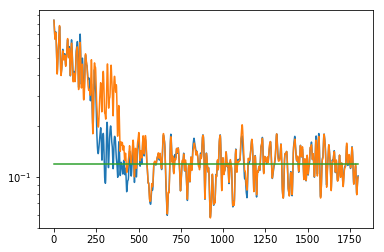

In [17]:
from scipy.ndimage.filters import gaussian_filter1d as gfilt

losses2 = np.array(losses2)
losses = np.array(losses)

for l in range(1):
    plt.plot(gfilt(losses[:,l]/100,3))
    
for l in range(1):
    plt.plot(gfilt(losses2[:,l]/100,3))
    
plt.plot([0,len(losses2)],[(V[1]**2 + V[0]**2)/2,(V[1]**2 + V[0]**2)/2])
plt.yscale("log")
plt.show()

In [ ]:
pred = []
activ = []

for k in range(0,20):
    repl_dict = {}
    for j in range(len(A.layers)):
        repl_dict[A.init_activity[j]] = final_act[j]


    repl_dict[A.data] = var[:,tlen*k : tlen * (k+1)]

    P,final_act = sess.run([A.get_attribute("prediction"),A.final_activation],repl_dict)
    pred.append(P)
#    activ.append(sct)
    print("{}".format(round(float(k*tlen)/len(var),2)))
sess.close()

In [ ]:
p1 = np.concatenate(np.squeeze(np.array([p[0] for p in pred])))

In [ ]:
print(p1.shape)
plt.plot(p1)
plt.plot(var[0,:2000])
plt.ylim([-2,2])
plt.show()

plt.plot(p1 - var[0,:2000,0])
plt.ylim([-2,2])
plt.show()